# Financial Econometrics
#### LE Son Tung & NGUYEN Thi Ha Giang

In [1]:
import numpy as np
import pandas as pd
import random as rd
import scipy.stats
import matplotlib.pyplot as plt
import math
from decimal import Decimal

With $\epsilon_t = \dfrac{S_t-S_{t-1}}{S_{t-1}}$, under risk neutral probability Q:
$$\begin{cases}
        \epsilon_t = \sigma_t Z_t^{'} + r\\
        \sigma^2_t = \omega + \alpha \sigma^2_{t-1}(Z_{t-1}^{'}-\lambda)^2 + \beta \sigma^2_{t-1}
        \end{cases}$$
$Var(\epsilon_t) = \dfrac{\omega}{1-\alpha(1+\lambda^2)-\beta}$

# Simulation GARCH(1,1) with $\lambda = 0$

In [3]:
class garch:
    """
    epsilon: simulations of GARCH(1,1)
    price: simulations of asset price
    call_payoff(K): simulations of call's payoff at time T for the strike price K
    call_price(K): return estimated price and standard deviation of call option with the strike price K, 
                    and the maturity T based on MC method
    """
    def __init__(self,w,a,b,r,T,N):
        self.w = w
        self.a = a
        self.b = b
        self.N = N
        self.r = r
        self.T = T
        sigma = np.ones((N, T)) * w / (1-a-b)
        epsilon = np.zeros((N, T))
        price = np.ones((N, T+1))
        epsilon[:, 1] = np.sqrt(sigma[:, 1]) * np.random.normal(0,1,N) + r
        
        for i in range(1,self.T,1):
            sigma[:, i] = w + a * (epsilon[:, i-1]-r) ** 2 + b * sigma[:, i-1]
            epsilon[:, i] = np.sqrt(sigma[:, i]) * np.random.normal(0,1,N) + r
        
        for i in range(1,T+1,1):
            price[:, i] = price[:, i-1] * (1 + epsilon[:, i-1])
        
        self.epsilon = epsilon
        self.sigma = sigma
        self.price = price
    
    def call_payoff(self,K):
        if isinstance(K, list):
            n = len(K)
        else:
            n = 1
        payoff = np.repeat(self.price[:, self.T], n).reshape((-1,n)) - K
        payoff[payoff<0] = 0
        return payoff
    
    def call_price(self,K):
        if isinstance(K, list):
            n = len(K)
        else:
            n = 1
        payoff = np.repeat(self.price[:, self.T], n).reshape((-1,n)) - K
        payoff[payoff<0] = 0
        return np.mean(payoff,axis = 0)/(1+self.r)**T, np.std(payoff,axis = 0)/math.sqrt(self.N)/(1+self.r)**(T)

In [4]:
w = 6.6*10**-6
a = 0.3
b = 0.66
r = 2*10**-4
T = 250
N = 100000
S = 1

### Analysis of daily returns GARCH(1,1)
The distribution of daily returns of GARCH(1,1) model has very high Kurtosis.
It reflects the Heavy-tail characteristics of financial risks. 

In [5]:
rd.seed(100)
np.random.seed(100)
returns = garch(w, a , b, r , T= 10**6, N = 1).epsilon.flatten()

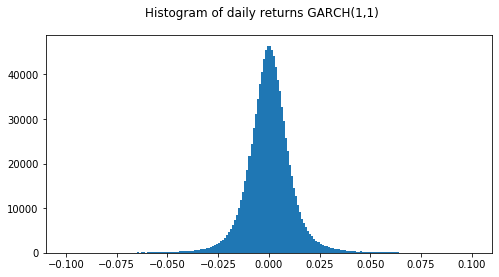

In [6]:
plt.figure(figsize=(8, 4))
plt.hist(returns, bins = 200, range = (-0.1,0.1))
plt.suptitle('Histogram of daily returns GARCH(1,1)')
plt.show()

In [24]:
print('Mean: ',np.mean(returns))
print('Variance: ', np.sqrt(np.var(returns)))
print('Skewness: ',scipy.stats.skew(returns, bias=False))
print('Kurtosis: ',scipy.stats.kurtosis(returns, bias=False))

Mean:  0.00020934537155226223
Variance:  0.012465355105868424
Skewness:  0.5775168950076784
Kurtosis:  79.35686796952916


### Simulation's graphs

In [8]:
rd.seed(10)
np.random.seed(10)
simulation_garch = garch(w, a , b, r , T, N = 100000)

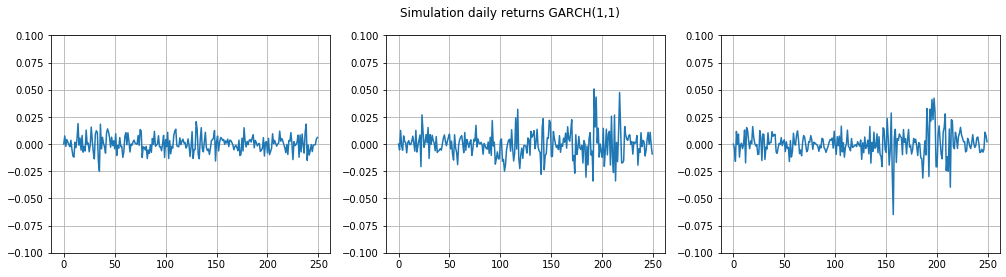

In [9]:
m = 3
plt.figure(figsize=(17, 4))

for i in range(m):
    plt.subplot(1, m, i+1)
    plt.plot(simulation_garch.epsilon[i,:])
    plt.ylim(-0.1,0.1)
    plt.grid()
plt.suptitle('Simulation daily returns GARCH(1,1)')
plt.show()

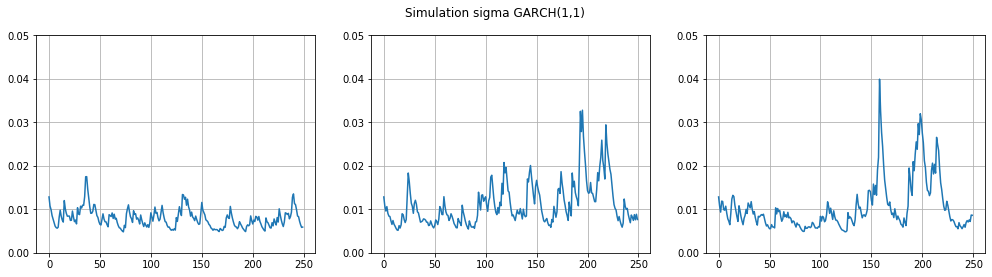

In [10]:
m = 3
plt.figure(figsize=(17, 4))

for i in range(m):
    plt.subplot(1, m, i+1)
    plt.plot(np.sqrt(simulation_garch.sigma[i,:]))
    plt.ylim(0,0.05)
    plt.grid()
plt.suptitle('Simulation sigma GARCH(1,1)')
plt.show()

Text(0.5, 0.98, 'Prices of asset with GARCH(1,1)')

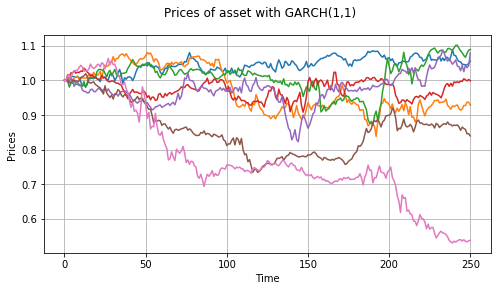

In [11]:
m = 7
plt.figure(figsize=(8, 4))
for i in range(m):
    plt.plot(simulation_garch.price[i,:])
plt.grid()
plt.xlabel('Time')
plt.ylabel('Prices')
plt.suptitle('Prices of asset with GARCH(1,1)')

### Call's price

In [12]:
w=6.6*10**-6
a = 0.3
b= 0.66
r = 2*10**-4
rc = math.log(1+r)
T= 250
N = 100000
S = 1

In [13]:
N_sim = [100, 200, 500, 1000, 2000, 5000, 10000, 20000,  50000, 100000, 200000]
K = 1.05
l = len(N_sim)
P = np.zeros((2, l))
rd.seed(1)
np.random.seed(1)
for i in range(l):
    P[:, i] = garch(w=6.6*10**-6, a = 0.1, b= 0.86, r = 2*10**-4, T= 250, N=N_sim[i]).call_price(K)

In [14]:
d = {'Number of simulations': N_sim, 'Call price': P[0,:], 'Standard deviation' : P[1,:]}
performance = pd.DataFrame(data=d).T
performance

,0,1,2,3,4,5,6,7,8,9,10
Number of simulations,100.000000,200.000000,500.000000,1000.000000,2000.000000,5000.000000,10000.000000,20000.000000,50000.000000,100000.000000,200000.000000
Call price,0.109387,0.084657,0.092058,0.077690,0.078091,0.077877,0.078158,0.079719,0.080287,0.079263,0.079696
Standard deviation,0.016527,0.009202,0.006484,0.004135,0.002895,0.001855,0.001308,0.000940,0.000597,0.000424,0.000300


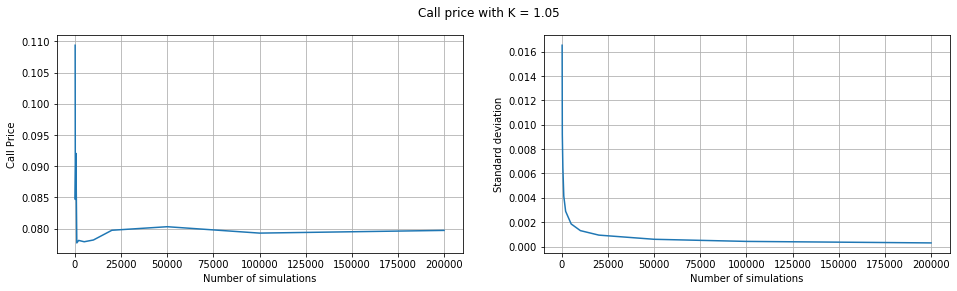

In [15]:
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.plot(N_sim, P[0,:])
plt.xlabel('Number of simulations')
plt.ylabel('Call Price')
plt.grid()
plt.subplot(1,2,2)
plt.plot(N_sim, P[1,:])
plt.xlabel('Number of simulations')
plt.ylabel('Standard deviation')
plt.grid()
plt.suptitle('Call price with K = 1.05')
plt.show()

In [16]:
Call_price = simulation_garch.call_price(K=np.arange(0.5,2,0.01))[0]
K = np.arange(0.5,2,0.01)

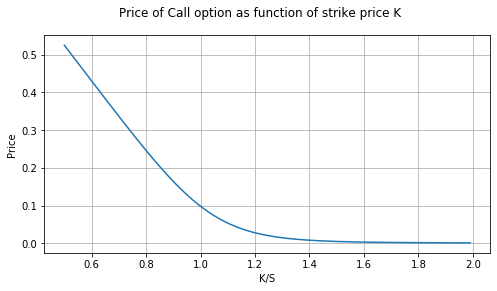

In [17]:
plt.figure(figsize=(8, 4))
plt.plot(K/S, Call_price)
plt.xlabel('K/S')
plt.ylabel('Price')
plt.grid()
plt.suptitle('Price of Call option as function of strike price K')
plt.show()

# Implied Volatility

In [18]:
from scipy.stats import norm

def Call_BS(S,K,T,rc,sigma):
    d1 = (np.log(S/K) + (rc + 1/2*sigma**2)*T)/sigma/np.sqrt(T)
    d2 = d1 - sigma*np.sqrt(T)
    return S*scipy.stats.norm.cdf(d1,0,1) - K*math.exp(-rc*T)*scipy.stats.norm.cdf(d2,0,1)

def Call_Vega(S,K,T,rc,sigma):
    d1 = (np.log(S/K) + (rc + 1/2*sigma**2)*T)/sigma/np.sqrt(T)
    return S*scipy.stats.norm.pdf(d1,0,1)*np.sqrt(T)

Implied volatility is the solution for the equation: $P_{market}(S,K,T) = P_{BSCall}(S,K,T,r,\sigma^*)$

Newton_Raphson method: $\sigma^{(i+1)} = \sigma^{(i)} - \frac{P_{BSCall}(\sigma^{(i)})-P_{market}}{\mathcal{V}(\sigma^{(i)})}$ where $\mathcal{V}(\sigma^{(i)}) = \dfrac{\partial P_{BSCall}(\sigma^{(i)})}{\partial \sigma^{(i)}}$

Secant method: replace $\mathcal{V}(\sigma^{(i)})$ by $\dfrac{P_{BSCall}(\sigma^{(i)})-P_{BSCall}(\sigma^{(i-1)})}{\sigma^{(i)}-\sigma^{(i-1)}}$

#### Calculation of Implied volatility using Newton-Raphson method

In [19]:
def Implied_Volatility_NR(CP,S,K,T,rc):
    sigma = 0.01
    sigma_0 = 0.02
    d1 = (np.log(S/K) + (rc + 1/2*sigma_0**2)*T)/sigma_0/np.sqrt(T)
    d2 = d1 - sigma_0*np.sqrt(T)
    while abs(Call_BS(S,K,T,rc,sigma)-CP) > 10**-6>10**-6:
        sigma_0 = sigma
        sigma = sigma_0 - (Call_BS(S,K,T,rc,sigma_0) - CP) / Call_Vega(S,K,T,rc,sigma_0)
    return sigma

#### Calculation of Implied volatility using Secant method

In [20]:
def Implied_Volatility_secant(CP,S,K,T,rc):
    sigma = 0.1
    sigma_0 = 0.02
    sigma_1 = 0.01
    while abs(Call_BS(S,K,T,rc,sigma)-CP) > 10**-6:
        Q = (Call_BS(S,K,T,rc,sigma_1)-Call_BS(S,K,T,rc,sigma_0))/(sigma_1-sigma_0)
        sigma = sigma_1 - (Call_BS(S,K,T,rc,sigma_1)-CP)/Q
        sigma_0 = sigma_1
        sigma_1 = sigma
    return(sigma)

In [21]:
volatility = np.arange(0.5,2,0.01)
for i in range(len(K)):
    volatility[i] = Implied_Volatility_secant(Call_price[i],S,K[i],T,rc)

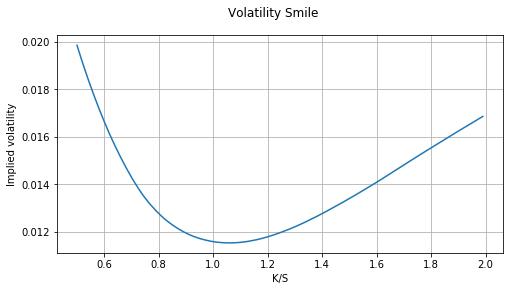

In [22]:
plt.figure(figsize=(8, 4))
plt.plot(K/S, volatility)
plt.xlabel('K/S')
plt.ylabel('Implied volatility')
plt.grid()
plt.suptitle('Volatility Smile')
plt.show()

In [23]:
diff = 0
for i in range(len(K)):
    diff = diff + (Call_BS(S,K[i],T,rc,volatility[i])-Call_price[i])**2
print(diff)

1.329350456608911e-11
